In [112]:
import argparse
import cvxpy as cp
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

In [113]:
def get_rand_mean_sigma(d):
    mu        = np.random.rand(d)
    sigma_tmp = np.random.rand(d, d)
    sigma     = np.dot(sigma_tmp, sigma_tmp.transpose())
    return mu, sigma

In [114]:
num_samples = 1_000
batch_size  = 10

In [115]:
mu_G, sigma_G = get_rand_mean_sigma(5)
mu_L, sigma_L = get_rand_mean_sigma(5)
mu_N, sigma_N = get_rand_mean_sigma(5)

G = np.random.multivariate_normal(mu_G, sigma_G, num_samples)
L = np.random.multivariate_normal(mu_L, sigma_L, num_samples)
N = np.random.multivariate_normal(mu_N, sigma_N, num_samples)

# constants to match form of https://www.sciencedirect.com/science/article/pii/S1877705814011771?ref=pdf_download&fr=RR-2&rr=875e3f6f1afa2b0b
# but not strictly necessary for dynamics generation
g       = 1
U_0     = 1
theta_0 = 0

In [116]:
final_row = np.ones((G.shape[0], 4))
final_row[:,0] = final_row[:,3] = 0
final_row[:,2] = np.tan(theta_0)

xs = np.hstack([G, L, N])
As = np.transpose(np.array([
    np.hstack([G[:,:3], np.ones((G.shape[0],1)) * (g * np.cos(theta_0))]) / U_0,
    np.hstack([L[:,:3], np.zeros((L.shape[0],1))]),
    np.hstack([N[:,:3], np.zeros((N.shape[0],1))]),
    final_row,
]), (1,0,2))

Bs = np.transpose(np.array([
    G[:,3:] / U_0,
    L[:,3:],
    N[:,3:],
    np.zeros((G.shape[0], 2)),
]), (1,0,2))

xs = torch.from_numpy(xs).to(torch.float32)
As = torch.from_numpy(As).to(torch.float32)
Bs = torch.from_numpy(Bs).to(torch.float32)

In [131]:
class ContextualLQR(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        
        self.fc_A = nn.Linear(64, 16)
        self.fc_B = nn.Linear(64, 8)
        
        # self.conv_A = nn.Conv2d(1, 1, 3, padding="same")
        # self.conv_B = nn.Conv2d(1, 1, 3, padding="same")

    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        fc2_x = self.fc2(x)
        x     = F.relu(x + fc2_x)

        fc3_x = self.fc3(x)
        x     = F.relu(x + fc3_x)

        # for predictions of A matrix
        A = self.fc_A(x).reshape((-1,4,4))
        # A    = self.conv_A(fc_A)

        # for predictions of B matrix
        B = self.fc_B(x).reshape((-1,4,2))
        # B    = self.conv_B(fc_B)

        return A, B

In [132]:
import torch.optim as optim

net       = ContextualLQR()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

In [147]:
num_batches = num_samples // batch_size
losses = []
for epoch in range(50):  # loop over the dataset multiple times
    rolling_loss = 0
    for i in range(num_batches):
        x_batch, A_batch, B_batch = xs[i*batch_size:(i+1)*batch_size], As[i*batch_size:(i+1)*batch_size], Bs[i*batch_size:(i+1)*batch_size]
        optimizer.zero_grad()

        A_hat_batch, B_hat_batch = net(x_batch)
        loss = criterion(A_hat_batch, A_batch) + criterion(B_hat_batch, B_batch)
        loss.backward()
        optimizer.step()

        rolling_loss += loss.item()
    losses.append(rolling_loss)
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {rolling_loss}')
print('Finished Training')

[1,   100] loss: 0.9567443961277604


<Axes: >

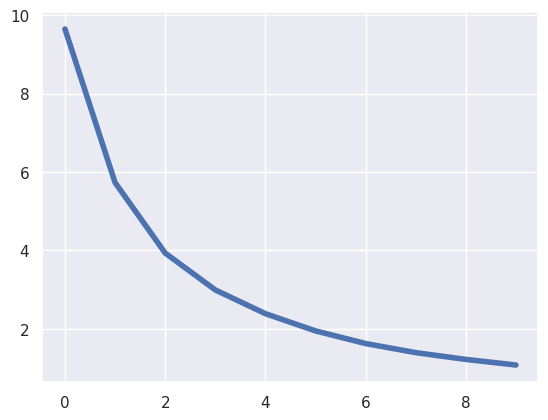

In [ ]:
import seaborn as sns
sns.set_theme()
sns.lineplot(x=range(10), y=losses, lw=4)